## Homework 4

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

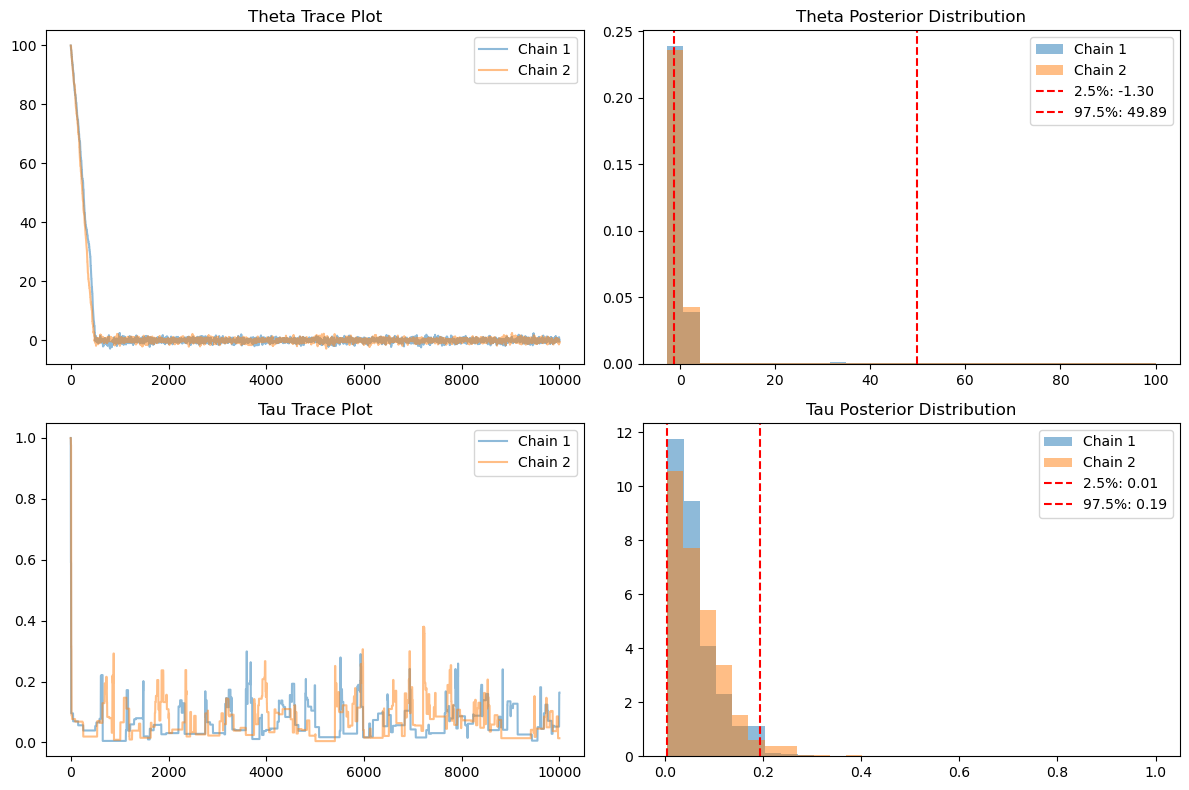

In [2]:
# Set sample size and generate data
n = 30  # Number of observations
sample_mean = 0  # True mean
sample_variance = 1  # True standard deviation
x = stats.norm(loc=sample_mean, scale=sample_variance).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta_0 = 0  # Prior mean for theta
tau_0 = 1  # Prior precision for theta
alpha = 2  # Shape parameter for Gamma prior on tau
lambda_param = 2  # Rate parameter for Gamma prior on tau


# Metropolis within Gibbs parameters
C, G = 2, 10000  # Number of chains and Gibbs samples
theta = np.zeros((C, G))
tau = np.ones((C, G))  # Initialize tau with positive values
theta[:, 0] = 100  # Initialization
# Independent proposal distribution for tau
proposal_shape, proposal_rate = alpha, lambda_param  # Gamma proposal

# Define joint density function
def log_joint_density(theta, tau):
    log_prior_theta = -0.5 * tau_0 * (theta - theta_0) ** 2 # Log-prior for theta(Normal)
    log_prior_tau = (alpha / 2 - 1) * np.log(tau) - (lambda_param / 2) * tau # Log-prior for tau (Gamma)
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2) # Log-likelihood(Gaussian) 
    
    # Return sum of log components (proportional to posterior log-density)
    return log_prior_theta + log_prior_tau + log_likelihood



for c in range(C):
    for g in range(1, G):
        # Sample theta using Metropolis-Hastings
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=0.5).rvs()
        
        log_acceptance_ratio_theta = log_joint_density(theta_proposal, tau[c, g-1]) - log_joint_density(theta[c, g-1], tau[c, g-1])
        
        if np.log(np.random.uniform()) < log_acceptance_ratio_theta:
            theta[c, g] = theta_proposal
        else:
            theta[c, g] = theta[c, g-1]

        # Metropolis-Hastings step for tau with Gamma proposal
        tau_proposal = stats.gamma(a=proposal_shape, scale=1/proposal_rate).rvs()
        
        log_acceptance_ratio_tau = log_joint_density(theta[c, g], tau_proposal) - log_joint_density(theta[c, g], tau[c, g-1])
        
        if np.log(np.random.uniform()) < log_acceptance_ratio_tau:
            tau[c, g] = tau_proposal
        else:
            tau[c, g] = tau[c, g-1]


# Plot the results
fig,axes = plt.subplots(2, 2, figsize=(12, 8))

for c in range(C):
    # Trace plot for theta
    axes[0, 0].plot(theta[c, :], alpha=0.5, label=f'Chain {c+1}')
    
    # Trace plot for tau
    axes[1, 0].plot(tau[c, :], alpha=0.5, label=f'Chain {c+1}')
    
    # Posterior histogram for theta
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    
    # Posterior histogram for tau
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

# compare it with the Gibbs sampler from Q2 in HW3, Compute credible intervals (2.5% and 97.5%)
theta_ci = np.percentile(theta.flatten(), [2.5, 97.5])
tau_ci = np.percentile(tau.flatten(), [2.5, 97.5])

# Overlay credible intervals on histograms
for ax, ci in zip([axes[0, 1], axes[1, 1]], [theta_ci, tau_ci]):
    ax.axvline(ci[0], color='r', linestyle='dashed', label=f'2.5%: {ci[0]:.2f}')
    ax.axvline(ci[1], color='r', linestyle='dashed', label=f'97.5%: {ci[1]:.2f}')
    
# Set titles
axes[0, 0].set_title("Theta Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Theta Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")


# Add legends
for ax in axes.flatten(): ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Metropolis within Gibbs shows more variabilityGibbs:The trace plots show that $\theta$ starts at 100 and quickly converges to near 0, but there is some noise. $\tau$shows a wider spread, meaning more uncertainty than in Gibbs Sampler(Q2 HW3)Gibbs.\
Posterior Histograms: Metropolis within Gibbs shows slightly wider due to random walk proposals and Gibbs Sampler (Q2 HW3)Gibbs shows Well-defined, smooth distributions.\
Credible Intervals:  Metropolis within Gibbs shows more variance due to proposal randomness and Gibbs Sampler (Q2 HW3)Gibbs clearly aligns with expected values.


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*


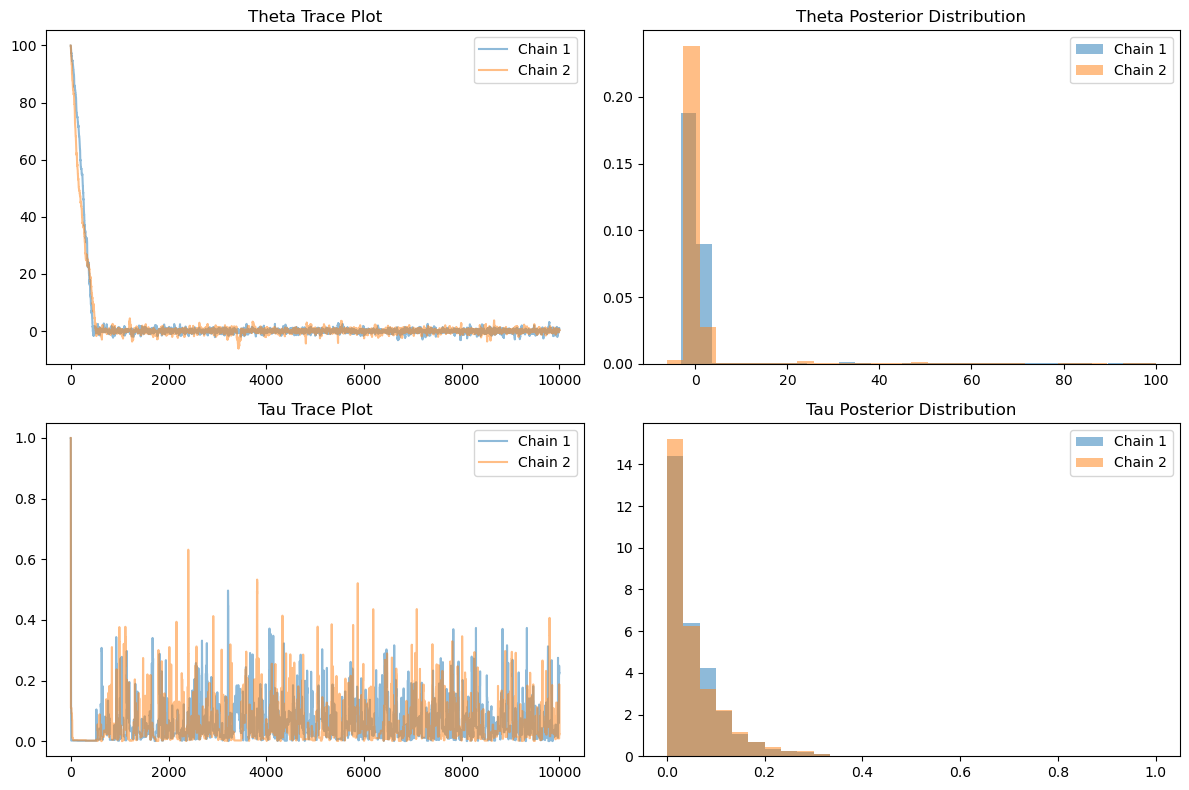

In [3]:
# Q2
# Set sample size and generate data
n = 30  # Number of observations
sample_mean = 0  # True mean
sample_variance = 1  # True standard deviation
x = stats.norm(loc=sample_mean, scale=sample_variance).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta_0 = 0  # Prior mean for theta
tau_0 = 1  # Prior precision for theta
alpha = 2  # Shape parameter for Gamma prior on tau
lambda_param = 2  # Rate parameter for Gamma prior on tau
s = 0.5  # Proposal scale for tau


# Metropolis within Gibbs parameters
C, G = 2, 10000  # Number of chains and Gibbs samples
theta = np.zeros((C, G))
tau = np.ones((C, G))  # Initialize tau with positive values
theta[:, 0] = 100  # Initialization

# Dependent proposal distribution for tau
# Truncated normal proposal for tau
def truncated_normal_proposal(tau_prev, scale):
    return stats.truncnorm(a=-tau_prev/scale, b=np.inf, loc=tau_prev, scale=s).rvs()

# Define joint density function with Non-Normal prior (e.g., Laplace prior)
def log_joint_density(theta, tau):
    log_prior_theta = -np.abs(theta - theta_0) / tau_0  # Laplace prior for theta
    log_prior_tau = (alpha / 2 - 1) * np.log(tau) - (lambda_param / 2) * tau  # Log-prior for tau (Gamma)
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2)  # Log-likelihood(Gaussian)
    
    # Return sum of log components (proportional to posterior log-density)
    return log_prior_theta + log_prior_tau + log_likelihood


for c in range(C):
    for g in range(1, G):
        # Sample theta using Metropolis-Hastings with Laplace prior
        theta_proposal = stats.laplace(loc=theta[c, g-1], scale=0.5).rvs()
        
        log_acceptance_ratio_theta = log_joint_density(theta_proposal, tau[c, g-1]) - log_joint_density(theta[c, g-1], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio_theta:
            theta[c, g] = theta_proposal
        else:
            theta[c, g] = theta[c, g-1]

        # Metropolis-Hastings step for tau using truncated normal proposal
        tau_proposal = truncated_normal_proposal(tau[c, g-1], s)
        
        log_acceptance_ratio_tau = log_joint_density(theta[c, g], tau_proposal) - log_joint_density(theta[c, g], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio_tau:
            tau[c, g] = tau_proposal
        else:
            tau[c, g] = tau[c, g-1]

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for c in range(C):
    # Trace plot for theta
    axes[0, 0].plot(theta[c, :], alpha=0.5, label=f'Chain {c+1}')
    
    # Trace plot for tau
    axes[1, 0].plot(tau[c, :], alpha=0.5, label=f'Chain {c+1}')
    
    # Posterior histogram for theta
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    
    # Posterior histogram for tau
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

# Set titles
axes[0, 0].set_title("Theta Trace Plot")
axes[1, 0].set_title("Tau Trace Plot")
axes[0, 1].set_title("Theta Posterior Distribution")
axes[1, 1].set_title("Tau Posterior Distribution")

# Add legends
for ax in axes.flatten(): ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Deriving full conditional distributions is necessary when they are analytically available. Gibbs sampling allows direct sampling without rejection, leading to faster mixing and better efficiency. However, when using non-conjugate priors or complex likelihoods (e.g., a Laplace prior for $\theta$), Metropolis within Gibbs becomes essential, as full conditionals may not have closed-form solutions. While Metropolis-Hastings introduces rejection steps and requires tuning, it provides flexibility for Bayesian inference in cases where direct Gibbs sampling is not feasible.


### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


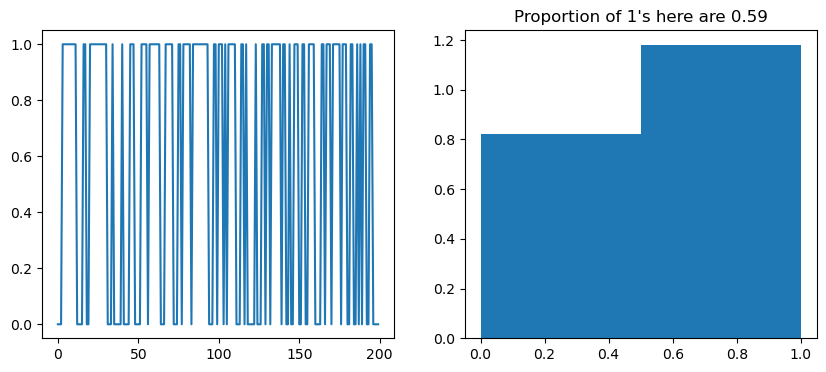

In [4]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]])  # Define the transition matrix
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

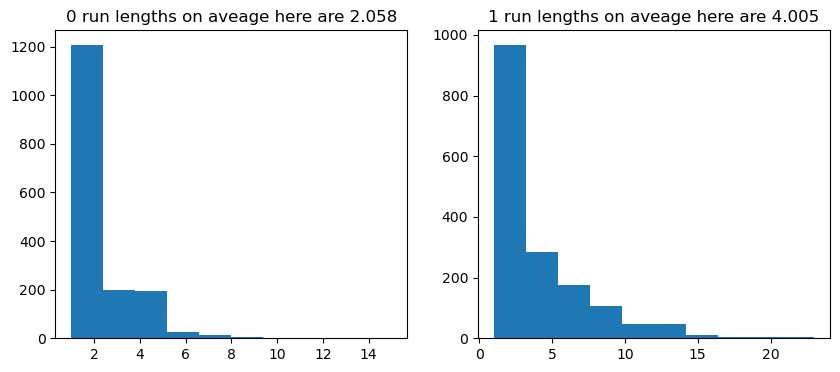

In [5]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


#### Q3

Step 1: Understanding the Problem
- A given proposal distribution: 
$$
q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)=\left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}}\left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$
we can get 
$$
q(0 \mid 1)=q(1 \mid 0)=\frac{1}{2}, \quad q(0 \mid 0)=q(1 \mid 1)=\frac{1}{2}
$$
- A given target stationary distribution: 
$$
p\left(x^{(t)}\right)=\left(\frac{1}{3}\right)^{1-x^{(t)}}\left(\frac{2}{3}\right)^{x^{(t)}}
$$
we can get 
$$
p(0)=\frac{1}{3}, \quad p(1)=\frac{2}{3}
$$
- The goal is to show that the transition kernel $K$ is correctly defined for the Metropolis-Hastings (MH) algorithm.

Step 2: Simplifying the Acceptance Probability

- The Metropolis-Hastings acceptance probability is:
$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right)=\min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)} \frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}\right)
$$

- As we get $q(0 \mid 1)=q(1 \mid 0)=q(0 \mid 0)=q(1 \mid 1)=\frac{1}{2}$, this means the proposal is symmetric $\frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}=1$. 
The proposal terms cancel, the acceptance probability will be:
$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right)=\min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)}\right)
$$
- This means that the acceptance ratio only depends on the target distribution $p\left(x^{(t)}\right)$

Step 3: Computing Transition Probabilities

- Substituting the by given distributions $p(0)=\frac{1}{3}, \quad p(1)=\frac{2}{3}$:
- Transition from $x$ = 0 to $x$ = 1
$$
\begin{aligned}
& \alpha(0 \rightarrow 1)=\min \left(1, \frac{p(1)}{p(0)}\right)=\min \left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right)=\min \left(1,2\right)=1
\end{aligned}
$$
Thus,
$$K(0 \rightarrow 1)=q(1 \mid 0) \cdot \alpha(0 \rightarrow 1)=\frac{1}{2} \cdot 1=0.5$$
Similarly, 
$$K(0 \rightarrow 0)= 1 - K(0 \rightarrow 1)=1-0.5=0.5$$

- Transition from $x$ = 1 to $x$ = 0
$$
\begin{aligned}
& \alpha(1 \rightarrow 0)=\min \left(1, \frac{p(0)}{p(1)}\right)=\min \left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right)=\min \left(1,\frac{1}{2} \right)=\frac{1}{2} 
\end{aligned}
$$
Thus,
$$
K(1 \rightarrow 0)=q(0 \mid 1) \cdot \alpha(1 \rightarrow 0)=\frac{1}{2} \cdot \frac{1}{2}=0.25
$$
And, 
$$
\begin{aligned}
K(1 \rightarrow 1) & =q(0 \mid 1) \cdot(1-\alpha(1 \rightarrow 0))+q(1 \mid 1)=\frac{1}{2} \cdot\left(1-\frac{1}{2}\right)+\frac{1}{2}=0.25+0.5=0.75
\end{aligned}
$$


Step 4: Constructing the Transition Kernel $K$
- Using the computed transition probabilities:
$$
K = \begin{bmatrix}
\Pr(0 \to 0) & \Pr(0 \to 1) \\
\Pr(1 \to 0) & \Pr(1 \to 1)
\end{bmatrix}
=
\begin{bmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{bmatrix}
$$

Step 5: check stationary distribution

The stationary distribution $\pi = [\pi_0, \pi_1]$ satisfies:

$$
\pi K = \pi
$$


Expanding into the System:
$$
\begin{aligned}
& \pi_0=0.5 \pi_0+0.25 \pi_1 \\
& \pi_1=0.5 \pi_0+0.75 \pi_1
\end{aligned}
$$


Using the normalization equation:
$$
\pi_0 + \pi_1 = 1
$$

Solving the System:
From the first equation:
$$
\begin{aligned}
& \pi_0 - 0.5\pi_0 = 0.25\pi_1\\
& 0.5\pi_0 = 0.25\pi_1\\
& \pi_0 = 0.5\pi_1
\end{aligned}
$$

Using the normalization equation:
$$
\begin{aligned}
& \pi_0 + \pi_1 = 1\\
& 0.5\pi_1 + \pi_1 = 1\\
& 1.5\pi_1 = 1\\
\end{aligned}
$$


Thus, the stationary distribution is exactly as expected:
$$
\pi_0 = \frac{1}{3}, \quad \pi_1 = \frac{2}{3}
$$
